# Region Perturbation POC

Compared to previous notebooks, this notebook should integrate inpainting for the first time as a perturbation technique to the pixel-flipping/region perturbation algorithm.

## LRP

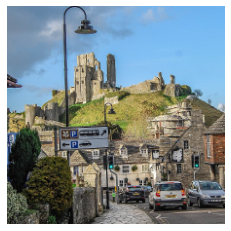

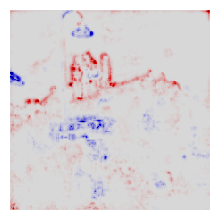

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict, Union, Tuple, Callable
import torchvision
import numpy
import torch

from lrp import image
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule
import lrp.rules as rules
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
from lrp.core import LRP
import lrp.plot

from matplotlib import pyplot as plt

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('../../data/castle.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

plt.axis('off')
lrp.plot.plot_imagenet_tensor(X)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=2, height=2)

## Region Perturbation

Try Region Perturbation with inpainting enabled.

Finished '__call__' in 18.0541 secs


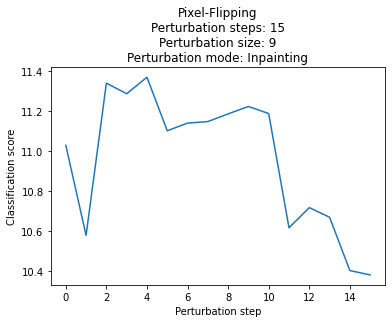

In [2]:
# %%script false --no-raise-error

# Parameters for cell: X, R, lrp_instance
from pf.perturbation_modes.constants import PerturbModes
from pf.pixel_flipping import PixelFlipping

perturbation_steps: int = 15
perturbation_size: int = 9

pixel_flipping: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.INPAINTING)
input: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float] = lambda input: lrp_instance.model.forward(input)[0][483].item()

# Run Pixel-Flipping algorithm
pixel_flipping(input, relevance_scores, forward_pass)

# Plot classification scores throughout perturbation steps
title: str = f'''Pixel-Flipping
Perturbation steps: {pixel_flipping.perturbation_steps}
Perturbation size: {pixel_flipping.perturbation_size}
Perturbation mode: {pixel_flipping.perturb_mode}'''
xlabel: str = 'Perturbation step'
ylabel: str = 'Classification score'
pixel_flipping.plot(title=title, xlabel=xlabel, ylabel=ylabel)

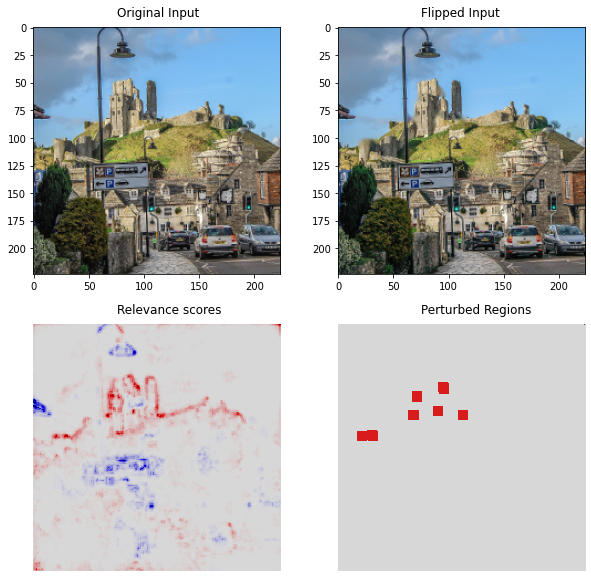

In [3]:
pixel_flipping.plot_image_comparison()

In [6]:
import pf.metrics

print(pf.metrics.area_under_the_curve(y=pixel_flipping.class_prediction_scores))
print(pf.metrics.area_over_the_curve(y=pixel_flipping.class_prediction_scores))

164.67178297042847
-163.67178297042847


In [48]:
import numpy as np
preds = pixel_flipping.class_prediction_scores
print(1-np.trapz(preds)) # negative score
print(len(preds)-np.trapz(preds)) # positive score

-163.67178297042847
-148.67178297042847


In [61]:
import sklearn.metrics

dx = 1.0
x = numpy.arange(0, perturbation_steps+1, dx)
y = pixel_flipping.class_prediction_scores
y_true = [y[0]]*len(y)

# auc = sklearn.metrics.auc(x, y)
auc = sklearn.metrics.roc_auc_score(y_true, y)

print(auc)
# WRONG

# min: float = 0.0
# max: float = 1.0

# scaled_auc = (auc - min) / (max - min)

# print(scaled_auc)

ValueError: continuous format is not supported

In [32]:
# WRONG:
# auc_manual = (numpy.array(y).mean())/(len(y)+1)
# auc_manual

0.6850626692175865

In [34]:
print(y)

[11.028932571411133, 10.577961921691895, 11.340609550476074, 11.287467956542969, 11.370137214660645, 11.101973533630371, 11.140374183654785, 11.148072242736816, 11.186531066894531, 11.22358226776123, 11.188231468200684, 10.61562728881836, 10.716879844665527, 10.668623924255371, 10.401450157165527, 10.37958812713623]


[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
0.0


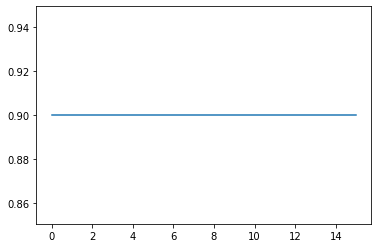

In [101]:
L: int = 1
# y = pixel_flipping.class_prediction_scores
y = [pixel_flipping.class_prediction_scores[0]] + [10.61562728881836]*(len(y)-1)
y: List[float] = numpy.array(y)
y_true: float = y[0]

delta_true_y: float = y_true - y
sum_delta_true_y: float = delta_true_y.sum()
# mean_delta_true_y: float = sum_delta_true_y.mean()
aopc: float = sum_delta_true_y/(L+1)

print(y)
print(delta_true_y)
print(sum_delta_true_y)
# print(mean_delta_true_y)
print(aopc)

plt.plot(y)
plt.show()

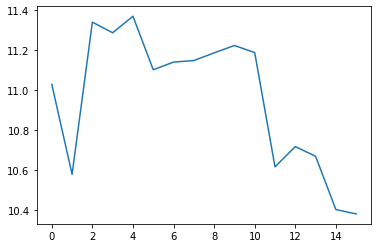

[1.         0.95911022 1.02825994 1.02344156 1.03093723 1.00662267
 1.01010448 1.01080247 1.01428955 1.01764901 1.01444373 0.96252536
 0.97170599 0.9673306  0.94310579 0.94112355]


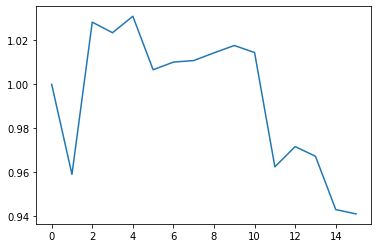

14.930890356269447


In [151]:
x = numpy.arange(0, perturbation_steps+1, dx)
y = numpy.array(pixel_flipping.class_prediction_scores)

plt.plot(x, y)
plt.show()

# print(y)
# y: List[float] = y[0] - y

min: float = 0.
max: float = y[0]
y = (y - min) / (max - min)
print(y)

plt.plot(x, y)
plt.show()

auc = sklearn.metrics.auc(x, y)
# max_auc = sklearn.metrics.auc(x, [1.0]*len(x))
auc = sklearn.metrics.auc(x, y)

print(auc)


In [78]:
def normalize_data(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

normalize_data(pixel_flipping.class_prediction_scores)

array([0.65553989, 0.2002665 , 0.97019061, 0.91654199, 1.        ,
       0.72927775, 0.76804478, 0.77581629, 0.81464205, 0.85204676,
       0.81635868, 0.23829123, 0.34050985, 0.29179351, 0.02207062,
       0.        ])

In [60]:
print(numpy.trapz(delta_true_y))
print(1-numpy.trapz(delta_true_y))
print(len(delta_true_y)-numpy.trapz(delta_true_y))

0.7622056007385254
0.2377943992614746
15.237794399261475


In [50]:
L = 1
y = numpy.array(y)
print(y/y[0])
np.trapz(y/y[0])

[1.         0.95911022 1.02825994 1.02344156 1.03093723 1.00662267
 1.01010448 1.01080247 1.01428955 1.01764901 1.01444373 0.96252536
 0.97170599 0.9673306  0.94310579 0.94112355]


14.930890356269447

In [57]:
np.arange(0, len(delta_true_y))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [83]:
y.round(decimals=2)[:5]

array([0.66, 0.2 , 0.97, 0.92, 1.  ])

In [85]:
y = normalize_data(pixel_flipping.class_prediction_scores)

import numpy as np
preds = [0.66, 0.2 , 0.97, 0.92, 1.]
print(1-np.trapz(preds)) # negative score
print(len(preds)-np.trapz(preds)) # positive score

-1.92
2.08


In [87]:
import numpy as np

preds: List[float] = [0.9, 0.7, 0.6, 0.5, 0.2]

print(np.trapz(preds))

print(1-np.trapz(preds)) # negative score
print(len(preds)-np.trapz(preds)) # positive score

2.35
-1.35
2.65


In [2]:
from typing import List

def area_over_the_curve(class_prediction_scores: List[float]) -> float:
    r'''Calculate the area over the curve (AOC) using the formula 12 from paper:

        Samek, Wojciech, Alexander Binder, Grégoire Montavon, Sebastian Lapuschkin, and Klaus-Robert Müller.
        "Evaluating the visualization of what a deep neural network has learned."
        IEEE transactions on neural networks and learning systems 28, no. 11 (2016): 2660-2673.

        (Chicago-style citation)

    :param y: List of Y values.

    :return: Area over the curve.
    '''
    y: numpy.array = numpy.array(class_prediction_scores)

    # L stands for the number of perturbation steps
    L: int = len(y)

    # y[0] - y represents the deviation of the class prediction scores (y) from the ground truth (y[0]).
    return (y[0] - y).sum() / (L + 1)

In [6]:
import numpy

preds: List[float] = [0.9, 0.7, 0.6, 0.5, 0.2]

area_over_the_curve([1]+[0.9]*(len(preds)-1))

0.06666666666666665

In [127]:
x = numpy.arange(0, len(preds))
print(sklearn.metrics.auc(x, preds))

2.35


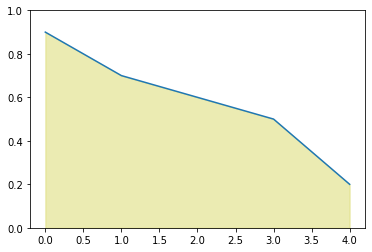

In [122]:
z=[0.9]*len(y)
plt.plot(preds,'-')
plt.ylim([0, 1])
plt.fill_between(numpy.arange(0,len(preds)), preds, color='y', alpha=0.3)
plt.show()

In [106]:
len(preds)

5

In [155]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
print(clf.predict_proba(X))
clf = LogisticRegression(solver="liblinear").fit(X, y)
roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

[[8.78030305e-01 1.21958900e-01 1.07949250e-05]
 [7.97058292e-01 2.02911413e-01 3.02949242e-05]
 [8.51997665e-01 1.47976480e-01 2.58550858e-05]
 [8.23406019e-01 1.76536159e-01 5.78217704e-05]
 [8.96034973e-01 1.03953836e-01 1.11907339e-05]
 [9.26234254e-01 7.37527845e-02 1.29612594e-05]
 [8.94096848e-01 1.05863935e-01 3.92166195e-05]
 [8.60034410e-01 1.39946715e-01 1.88751124e-05]
 [8.01028643e-01 1.98886755e-01 8.46025595e-05]
 [7.92662392e-01 2.07312003e-01 2.56051563e-05]
 [8.90486112e-01 1.09507726e-01 6.16178069e-06]
 [8.61800668e-01 1.38164963e-01 3.43688884e-05]
 [7.85364369e-01 2.14608265e-01 2.73660893e-05]
 [8.33122325e-01 1.66845600e-01 3.20746459e-05]
 [9.27105079e-01 7.28939564e-02 9.65025075e-07]
 [9.64209783e-01 3.57879589e-02 2.25815135e-06]
 [9.40244677e-01 5.97504819e-02 4.84124978e-06]
 [8.90383643e-01 1.09602199e-01 1.41584311e-05]
 [8.94996432e-01 1.04996803e-01 6.76561305e-06]
 [9.22818333e-01 7.71698511e-02 1.18163279e-05]
 [8.28168845e-01 1.71815986e-01 1.516976

0.9913333333333334

In [156]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
roc_auc_score(y_true, y_scores)

0.75

In [176]:
y_scores = numpy.array(pixel_flipping.class_prediction_scores)/pixel_flipping.class_prediction_scores[0]
y_true = numpy.array([pixel_flipping.class_prediction_scores[0]]*len(y_scores))/pixel_flipping.class_prediction_scores[0]

x = numpy.arange(0, len(y_scores))
sklearn.metrics.auc(x, y_scores)
# roc_auc_score(y_true, y_scores)

14.930890356269447

In [204]:
y_scores: numpy.array = numpy.array(pixel_flipping.class_prediction_scores)
y_scores = numpy.array([0.]*len(y_scores)); y_scores[0] = 1.
display(y_scores)
display(y_scores[0] - y_scores)
aopc: float = y_scores[0] - y_scores
aopc = aopc.sum()/perturbation_steps
display(aopc)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

1.0

In [213]:
y: numpy.array = numpy.array(pixel_flipping.class_prediction_scores)
pf.metrics.area_over_the_curve(y)

0.06393398958093979

In [174]:
print(y_scores)
print(y_true)

[1.         0.95911022 1.02825994 1.02344156 1.03093723 1.00662267
 1.01010448 1.01080247 1.01428955 1.01764901 1.01444373 0.96252536
 0.97170599 0.9673306  0.94310579 0.94112355]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
